In [1]:
import os

In [3]:
import torch

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
device

'cuda'

In [7]:
from torchtext.datasets import SQuAD1

In [8]:
train, test = SQuAD1("root")

In [9]:
from modules.data import get_dataframe,  get_pairs_from_df, cols, sample_df_perc, get_thresholds, get_outliers, tokenize_sentence, remove_least_common, to_tensor,  filter_sentences

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package wordnet to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# get train and test dataframes of sentences
train_df, test_df = get_dataframe(train), get_dataframe(test)

In [11]:
train_df = sample_df_perc(train_df, 0.2)

In [12]:
test_df = sample_df_perc(test_df, 0.2)

In [13]:
train_df.shape, test_df.shape

((17519, 2), (2114, 2))

In [14]:
train_df.head()

,Question,Answer
0,What type of bottle conditioned beer is custom...,wheat beers
1,What three points do most theists agree on?,"God is omnipotent, omniscient, and benevolent,"
2,Dog could also come from the original layer of...,Proto-Indo-European
3,How much is the Gordie Howe International Brid...,$2.1 billion
4,What is considered as an alternative to tofu f...,Freshwater fish and shrimp have been incorpora...


In [16]:
import random

rand_question = train_df.at[random.randint(0,train_df.shape[0]), 'Question']
print(rand_question)

print(tokenize_sentence(rand_question))
print(tokenize_sentence(rand_question, normalization='stem'))

What did the Bush administration describe as heroic?
['what', 'bush', 'administration', 'describe', 'heroic']
['what', 'bush', 'administr', 'describ', 'heroic']


# Vocabulary

In [17]:
from modules.vocab import Vocab

## Make pairs to add to the vocabularies. 

#### Only the questions will be normalized (stemmed) but not the answers - otherwise we would get stemmed words in the chatbot answers

In [18]:
for col, norm in zip(cols, ['stem', None]):
    train_df[f'{col}_tokens'] = train_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [19]:
for col, norm in zip(cols, ['stem', None]):
    test_df[f'{col}_tokens'] = test_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [20]:
train_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
255,What countries other than Brazil was Brazil's ...,"UK, Germany","[what, countri, brazil, brazil, wave, music, e...","[uk, germany]"
14695,What do modern hunters see themselves as?,conservationists and sportsmen,"[what, modern, hunter, see]","[conservationists, sportsmen]"
2193,Which book did Victoria publish that did nothi...,Leaves from the Journal of Our Life in the Hig...,"[which, book, victoria, publish, noth, take, a...","[leaves, journal, life, highlands]"


In [21]:
test_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
1073,When the law is a direct target of the protest...,direct civil disobedience,"[when, law, direct, target, protest, what, call]","[direct, civil, disobedience]"
824,What music did the fourth soundtrack feature?,music from the 2008–2010 specials,"[what, music, fourth, soundtrack, featur]","[music, 2008, 2010, specials]"
365,Why was old oil withdrawn from the market?,Price controls,"[whi, old, oil, withdrawn, market]","[price, controls]"


In [22]:
cols_tokens = [f'{col}_tokens' for col in cols]

In [23]:
train_pairs = get_pairs_from_df(train_df, cols_tokens)

In [24]:
test_pairs = get_pairs_from_df(test_df, cols_tokens)

In [25]:
Q_vocab, A_vocab = Vocab(), Vocab()

In [26]:
for pair in train_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [27]:
Q_vocab.n_words, A_vocab.n_words, 

(12974, 16051)

In [28]:
for pair in test_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [29]:
Q_vocab.n_words, A_vocab.n_words 

(13877, 17283)

## Functions for some data analysis

In [30]:
from modules.stats import sentences_stats, histograms

In [31]:
# statistics for tokenized sentences
sentences_stats(train_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.44
	         median: 6.00
	         minimum: 0
	         maximum: 22)
Sentences in column Answer_tokens:
	         mean: 2.41
	         median: 2.00
	         minimum: 0
	         maximum: 22)


In [32]:
# statistics for tokenized sentences
sentences_stats(test_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.53
	         median: 6.00
	         minimum: 2
	         maximum: 17)
Sentences in column Answer_tokens:
	         mean: 2.33
	         median: 2.00
	         minimum: 0
	         maximum: 15)


## Remove the least common words from the sentences

In [33]:
# how many times at most a word occurs to be considered an outlier
outlier_threshold = 1

In [34]:
get_outliers(Q_vocab, outlier_threshold+1), get_outliers(A_vocab, outlier_threshold+1)

(['customarili',
  'pour',
  'yeast',
  'theist',
  'gordi',
  'howe',
  'tofu',
  'creationist',
  'steet',
  'abilen',
  'pocketfami',
  'muddi',
  'statesman',
  'tuvalus',
  'georgius',
  'gemistus',
  'pletho',
  'angara',
  'intelligentia',
  'abakiton',
  'institud',
  'curonian',
  'plantarum',
  '1544',
  'wherev',
  'pygostyl',
  'tail',
  'fuller',
  'nearinfrar',
  'brickhous',
  'ltro',
  'turbogener',
  'newgat',
  'parapodia',
  'burrow',
  'motorway',
  'derech',
  'eretz',
  'qatar',
  'blockhous',
  'nonscienc',
  'h3',
  'tamer',
  'isoniazid',
  'whitbi',
  'cheshir',
  'uboat',
  'attbel',
  'cyril',
  'pentagon',
  'funday',
  'geoff',
  'travi',
  '1641',
  'immunoassay',
  'dormant',
  'skeleton',
  'etc',
  'bandwidth',
  'g20',
  'intersect',
  'xgerat',
  'leisur',
  'lossi',
  'kilim',
  'botan',
  'kharkiv',
  'betalactam',
  'lifecycl',
  'implicit',
  'brutal',
  'hurt',
  'antibacteri',
  'paleontologist',
  'spectacular',
  'cacoyanni',
  'phoenican',
 

In [35]:
q_outliers, a_outliers = get_outliers(Q_vocab,outlier_threshold+1), get_outliers(A_vocab,outlier_threshold+1)

In [36]:
train_df_final = remove_least_common(train_df, cols_tokens, [q_outliers, a_outliers])

In [37]:
test_df_final = remove_least_common(test_df, cols_tokens, [q_outliers, a_outliers])

In [38]:
# tokenized & least common removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.07
	         median: 6.00
	         minimum: 0
	         maximum: 21)
Sentences in column Answer_tokens:
	         mean: 1.85
	         median: 1.00
	         minimum: 0
	         maximum: 20)


# remove questions that have less than three words and answers that have less than 1


## Remove long outliers: long sentences that occure rarely

In [39]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


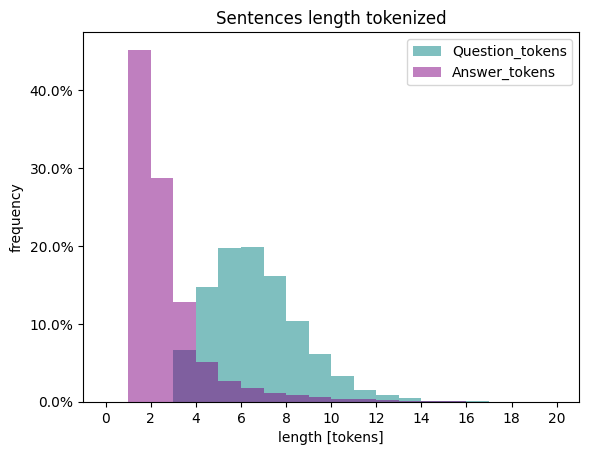

In [40]:
train_df_final_thresholds = histograms(train_df_final, cols_tokens, name = 'tokenized')

In [41]:
train_df_final.shape

(14397, 4)

In [42]:
# shortest sentences removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.18
	         median: 6.00
	         minimum: 3
	         maximum: 21)
Sentences in column Answer_tokens:
	         mean: 2.18
	         median: 2.00
	         minimum: 1
	         maximum: 20)


In [43]:
# keeping only the 95% of the data

cutoff = 95

In [44]:
# keeping only the 95% of the data

get_thresholds(train_df_final_thresholds, cutoff = cutoff)

{'Question_tokens': 10, 'Answer_tokens': 6}

In [45]:
Q_MAX, A_MAX = get_thresholds(train_df_final_thresholds, cutoff = cutoff).values()

In [46]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [47]:
# long outliers removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.01
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.93
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [48]:
train_df_final.shape

(13428, 4)

# Must make pairs from the dataset with removed short and long sequences

In [49]:
train_pairs_final = get_pairs_from_df(train_df_final, cols_tokens)

In [50]:
test_pairs_final = get_pairs_from_df(test_df_final, cols_tokens)

In [51]:
len(train_pairs_final), len(test_pairs_final)

(13428, 2114)

# building the model

In [52]:
from modules.models import Seq2Seq

In [53]:
hidden_size = 256

In [54]:
embedding_dim = 256

In [55]:
seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words)

In [56]:
seq2seq = seq2seq.to(device)

In [57]:
from torch import optim
import torch.nn as nn

In [58]:
learning_rate = 0.001
num_epochs = 5

In [59]:
optimizer = optim.SGD(seq2seq.parameters(), lr=learning_rate)
criterion = nn.NLLLoss().to(device)

In [60]:
def train(model, pairs, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    
    total_loss = 0
    
    for pair in pairs:
        
        src = pair.question
        tgt = pair.answer
        
        src_tensor = to_tensor(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
        tgt_tensor = to_tensor(vocab=A_vocab, tokens=tgt, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)

        print(src_tensor.shape, tgt_tensor.shape)
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        output = model(src_tensor, tgt_tensor, teacher_forcing_ratio=1)

        # Compute the loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    

    return total_loss / len(pairs)

In [61]:
for epoch in range(num_epochs):
    train_loss = train(seq2seq, train_pairs_final, optimizer, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

torch.Size([12, 1]) torch.Size([8, 1])


RuntimeError: input.size(-1) must be equal to input_size. Expected 256, got 3072